# Synthetic Control in PyMC

In this notebook we provide an example of how to implement a synthetic control problem in PyMC to answer a "what if this had happened?" type of question in the context of causal inference. We reproduce the results of the example provided in the great book [Causal Inference for The Brave and True](https://matheusfacure.github.io/python-causality-handbook/landing-page.html) by [Matheus Facure](https://matheusfacure.github.io/). Specifically, we look into the problem of estimating the *effect of cigarette taxation on its consumption* presented in Chapter [15 - Synthetic Control](https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html).

## Prepare Notebook

In [127]:
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
from pymc.distributions.continuous import Exponential
from sklearn.preprocessing import StandardScaler
import seaborn as sns


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext rich
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The rich extension is already loaded. To reload it, use:
  %reload_ext rich
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read Data

In [128]:
data_path = "https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/smoking.csv"

raw_data_df = pd.read_csv(data_path)

raw_data_df.head()

,state,year,cigsale,lnincome,beer,age15to24,retprice,california,after_treatment
0,1,1970,89.800003,NaN,NaN,0.178862,39.599998,False,False
1,1,1971,95.400002,NaN,NaN,0.179928,42.700001,False,False
2,1,1972,101.099998,9.498476,NaN,0.180994,42.299999,False,False
3,1,1973,102.900002,9.550107,NaN,0.182060,42.099998,False,False
4,1,1974,108.199997,9.537163,NaN,0.183126,43.099998,False,False


In [129]:
df = raw_data_df.copy().drop(columns=["lnincome", "beer", "age15to24"]).assign()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1209 entries, 0 to 1208
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   state            1209 non-null   int64  
 1   year             1209 non-null   int64  
 2   cigsale          1209 non-null   float64
 3   retprice         1209 non-null   float64
 4   california       1209 non-null   bool   
 5   after_treatment  1209 non-null   bool   
dtypes: bool(2), float64(2), int64(2)
memory usage: 40.3 KB


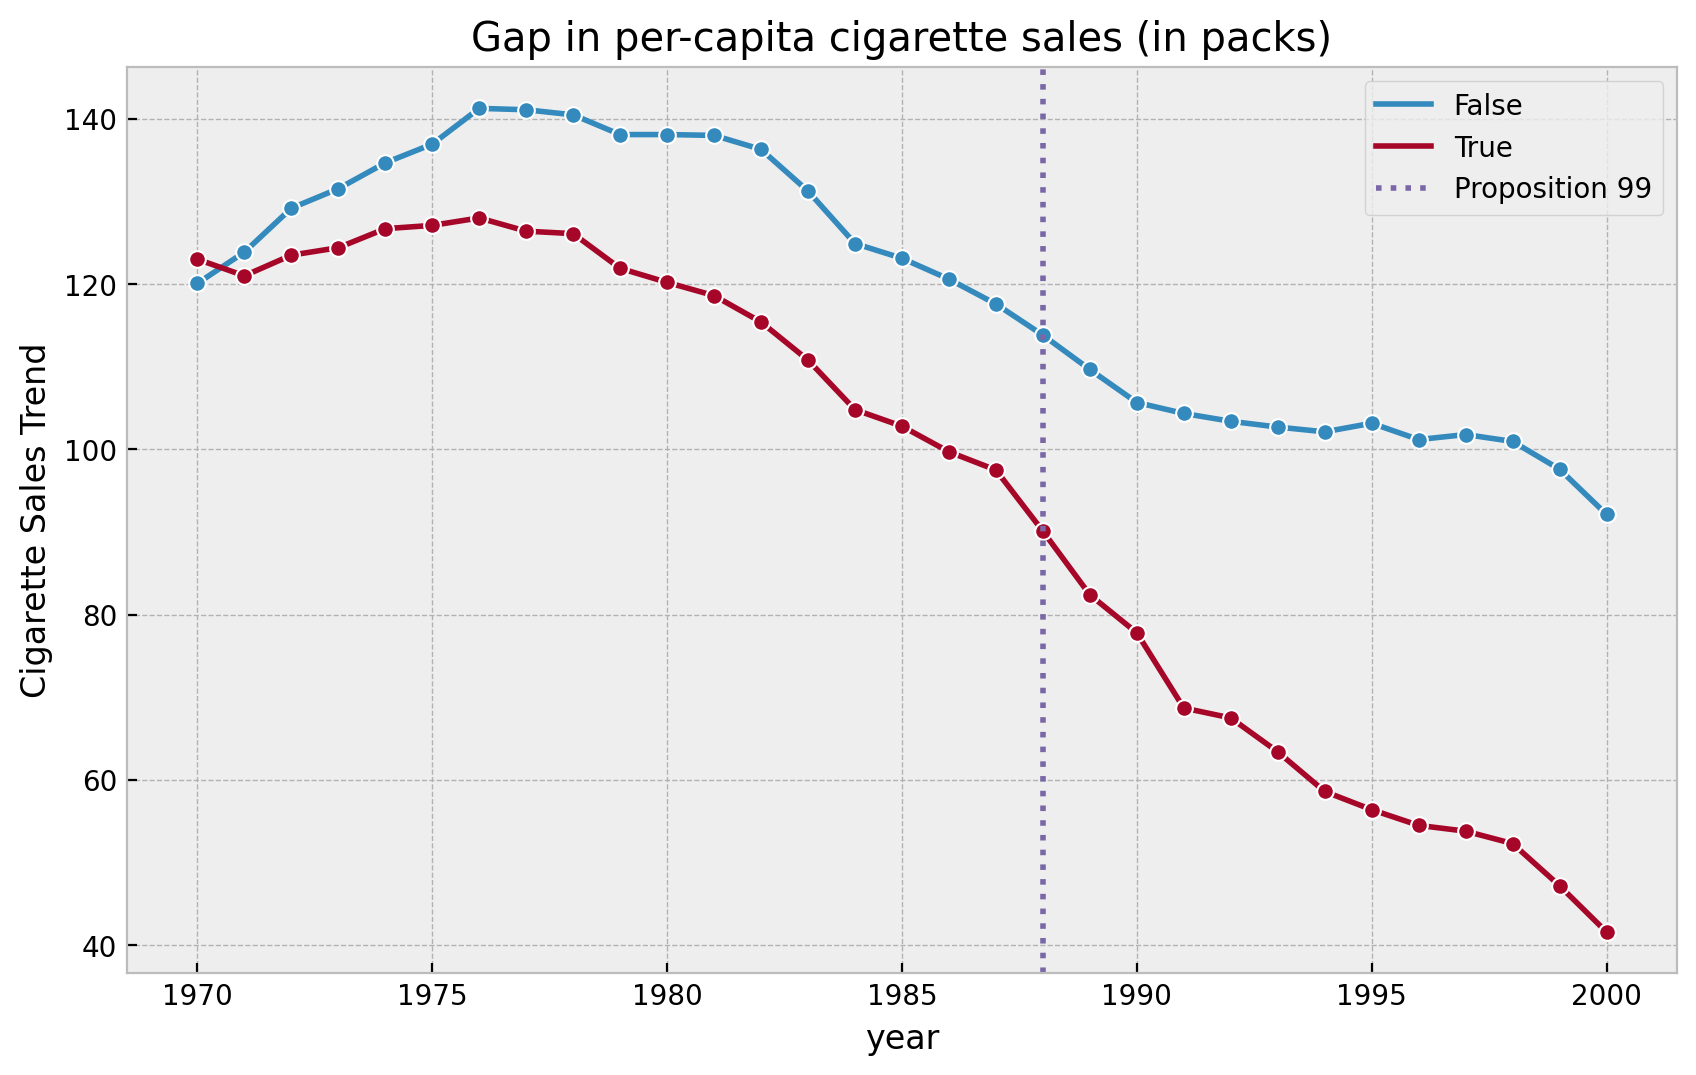

In [130]:
fig, ax = plt.subplots()

(
    df.groupby(["year", "california"], as_index=False)
    .agg({"cigsale": np.mean})
    .pipe(
        (sns.lineplot, "data"),
        x="year",
        y="cigsale",
        hue="california",
        marker="o",
        ax=ax,
    )
)
ax.axvline(
    x=1988,
    linestyle=":",
    lw=2,
    color="C2",
    label="Proposition 99",
)
ax.legend(loc="upper right")
ax.set(
    title="Gap in per-capita cigarette sales (in packs)", ylabel="Cigarette Sales Trend"
);


In [131]:
features = ["cigsale", "retprice"]

pre_df = (
    df
    .query("~ after_treatment")
    .pivot(index='state', columns="year", values=features)
    .T
)

post_df = (
    df
    .query("after_treatment")
    .pivot(index='state', columns="year", values=features)
    .T
)

In [132]:
idx = 3

y_pre = pre_df[idx].to_numpy()
x_pre = pre_df.drop(columns=idx).to_numpy()
pre_years = pre_df.reset_index(inplace=False).year.unique()
n_pre = pre_years.size

y_post = post_df[idx].to_numpy()
x_post = post_df.drop(columns=idx).to_numpy()
post_years = post_df.reset_index(inplace=False).year.unique()
n_post = post_years.size

k = pre_df.shape[0]

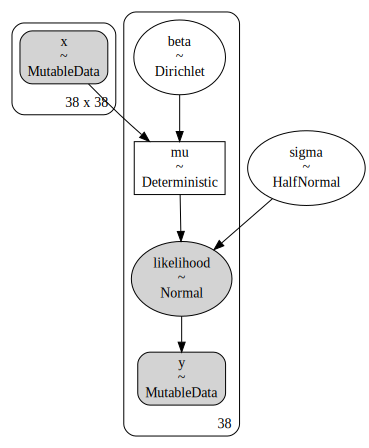

In [133]:
with pm.Model() as model:
    x = pm.MutableData(name="x", value=x_pre)
    y = pm.MutableData(name="y", value=y_pre)

    beta = pm.Dirichlet(name="beta", a=(1 / k) * np.ones(k))
    sigma = pm.HalfNormal(name="sigma", sigma=5)
    mu = pm.Deterministic(name="mu", var=pm.math.dot(x, beta))
    likelihood = pm.Normal(name="likelihood", mu=mu, sigma=sigma, observed=y)

pm.model_to_graphviz(model)

In [134]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(draws=4000, chains=4)
    posterior_predictive_pre = pm.sample_posterior_predictive(trace=idata)

Compiling...
Compilation time =  0:00:02.708101
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:00:13.788152
Transforming variables...
Transformation time =  0:00:00.094365
Computing Log Likelihood...
Log Likelihood time =  0:00:00.216953


100.00% [16000/16000 00:01<00:00]

In [135]:
az.summary(data=idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.001,0.004,0.000,0.001,0.000,0.000,2106.0,1906.0,1.0
beta[1],0.000,0.003,0.000,0.001,0.000,0.000,1830.0,977.0,1.0
beta[2],0.004,0.016,0.000,0.015,0.000,0.000,2500.0,2228.0,1.0
beta[3],0.004,0.016,0.000,0.025,0.000,0.000,2403.0,2195.0,1.0
beta[4],0.002,0.009,0.000,0.005,0.000,0.000,1796.0,1169.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[33],92.683,0.577,91.632,93.996,0.008,0.005,7300.0,6226.0,1.0
mu[34],100.340,0.717,98.773,101.758,0.008,0.006,8208.0,6095.0,1.0
mu[35],102.656,0.415,101.838,103.526,0.005,0.004,7591.0,6487.0,1.0
mu[36],111.019,0.458,109.944,111.792,0.006,0.005,6891.0,3764.0,1.0


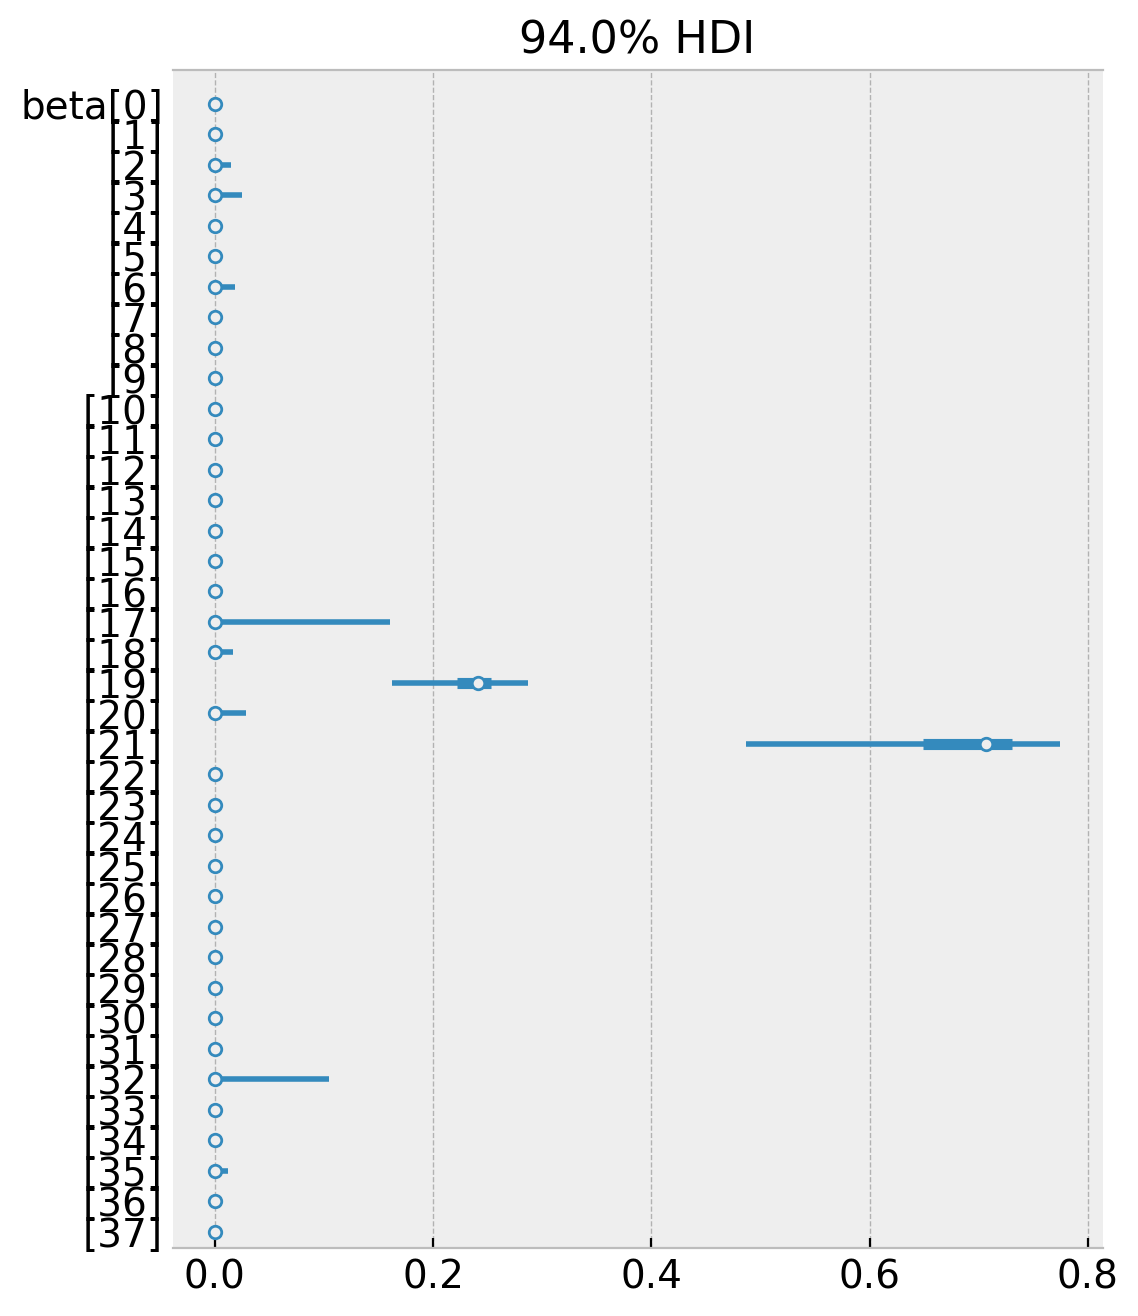

In [136]:
az.plot_forest(data=idata, combined=True, var_names=["beta"]);

In [137]:
np.unique(
    idata
    .posterior["beta"]
    .stack(samples=("chain", "draw"))
    .sum(axis=0)
    .to_numpy()
    - 1
)

array([-5.55111512e-16, -4.44089210e-16, -3.33066907e-16, -2.22044605e-16,
       -1.11022302e-16,  0.00000000e+00,  2.22044605e-16,  4.44089210e-16])

In [138]:
with model:
    pm.set_data(new_data={"x": x_post, "y": y_post})
    posterior_predictive_post = pm.sample_posterior_predictive(
        trace=idata, var_names=["likelihood"]
    )


100.00% [16000/16000 00:01<00:00]

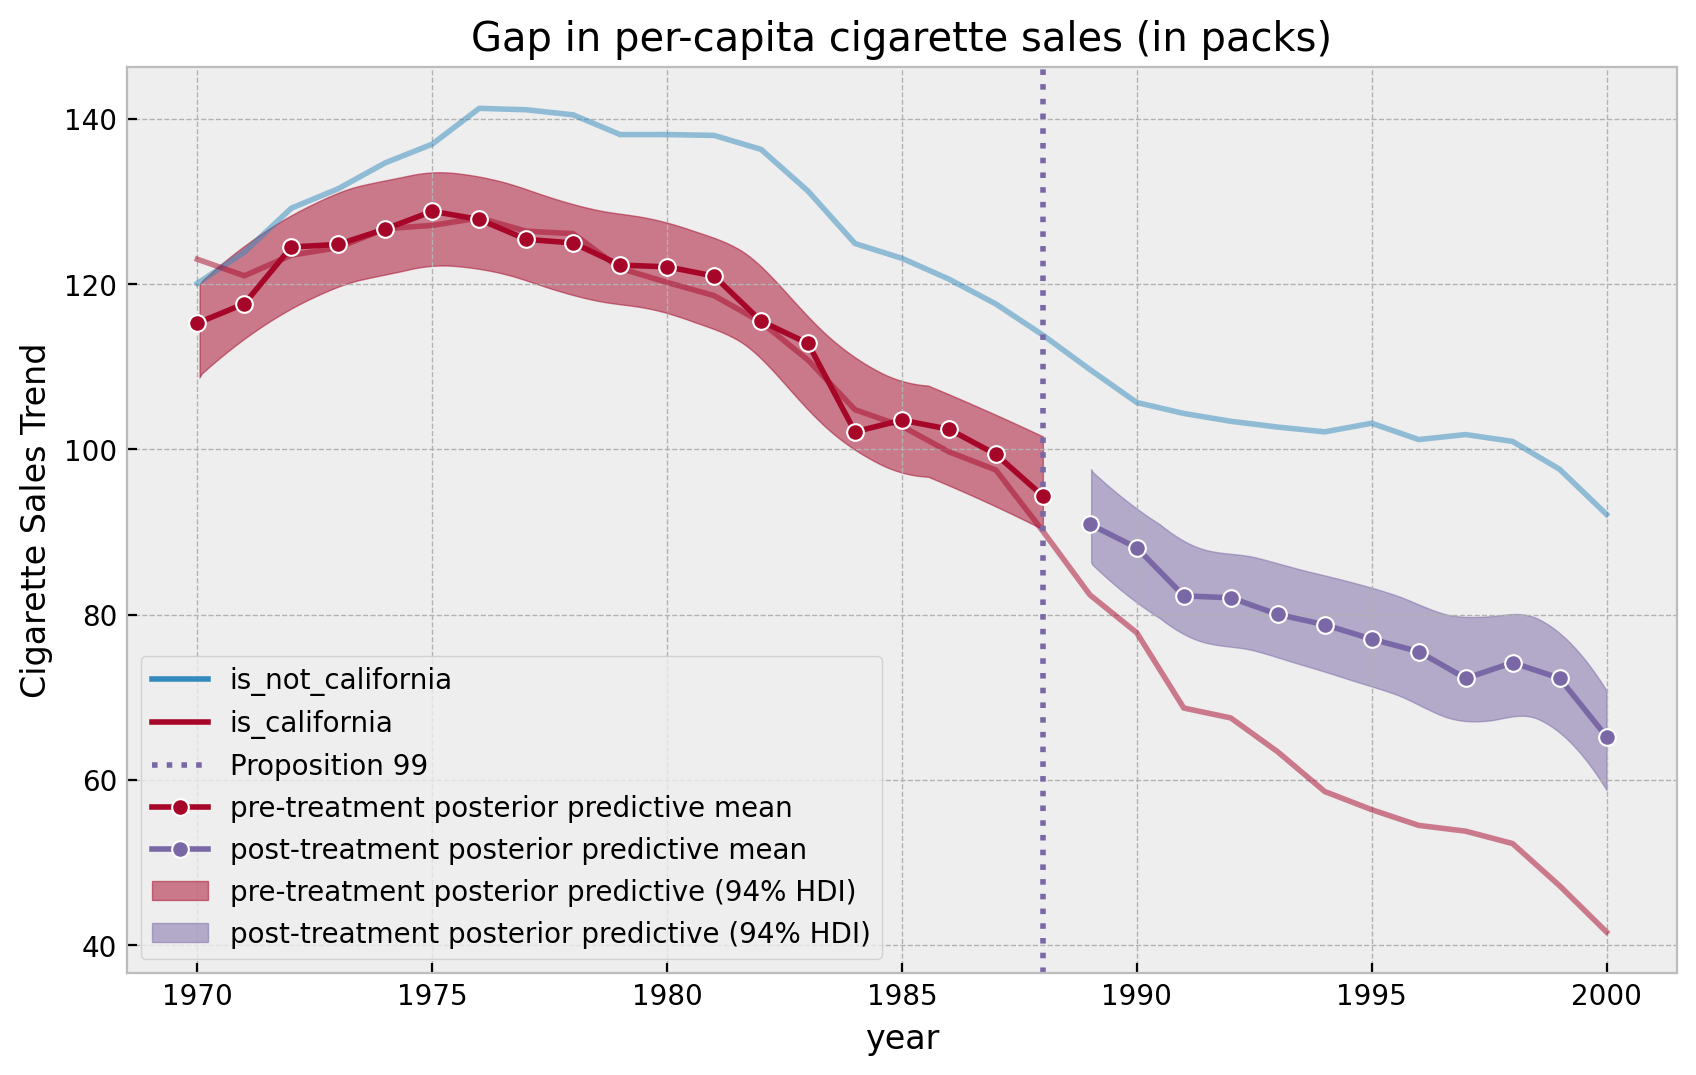

In [139]:
pre_posterior_mean = (
    posterior_predictive_pre
    .posterior_predictive
    ["likelihood"]
    [:, :, : n_pre]
    .stack(samples=("chain", "draw"))
    .mean(axis=1)
)

post_posterior_mean = (
    posterior_predictive_post
    .posterior_predictive
    ["likelihood"]
    [:, :, : n_post]
    .stack(samples=("chain", "draw"))
    .mean(axis=1)
)


fig, ax = plt.subplots()

(
    df.groupby(["year", "california"], as_index=False)
    .agg({"cigsale": np.mean})
    .assign(california=lambda x: x.california.map(
        {True: "is_california", False: "is_not_california"})
    )
    .pipe(
        (sns.lineplot, "data"),
        x="year",
        y="cigsale",
        hue="california",
        alpha=0.5,
        ax=ax,
    )
)
ax.axvline(
    x=1988,
    linestyle=":",
    lw=2,
    color="C2",
    label="Proposition 99",
)
sns.lineplot(
    x=pre_years,
    y=pre_posterior_mean,
    color="C1",
    marker="o",
    label="pre-treatment posterior predictive mean",
    ax=ax
)
sns.lineplot(
    x=post_years,
    y=post_posterior_mean,
    color="C2",
    marker="o",
    label="post-treatment posterior predictive mean",
    ax=ax
)
az.plot_hdi(
    x=pre_years,
    y=posterior_predictive_pre.posterior_predictive["likelihood"][:, :, : n_pre],
    smooth=True,
    color="C1",
    fill_kwargs={"label": "pre-treatment posterior predictive (94% HDI)"},
    ax=ax
)
az.plot_hdi(
    x=post_years,
    y=posterior_predictive_post.posterior_predictive["likelihood"][:, :, : n_post],
    smooth=True,
    color="C2",
    fill_kwargs={"label": "post-treatment posterior predictive (94% HDI)"},
    ax=ax
)
ax.legend(loc="lower left")
ax.set(
    title="Gap in per-capita cigarette sales (in packs)", ylabel="Cigarette Sales Trend"
);


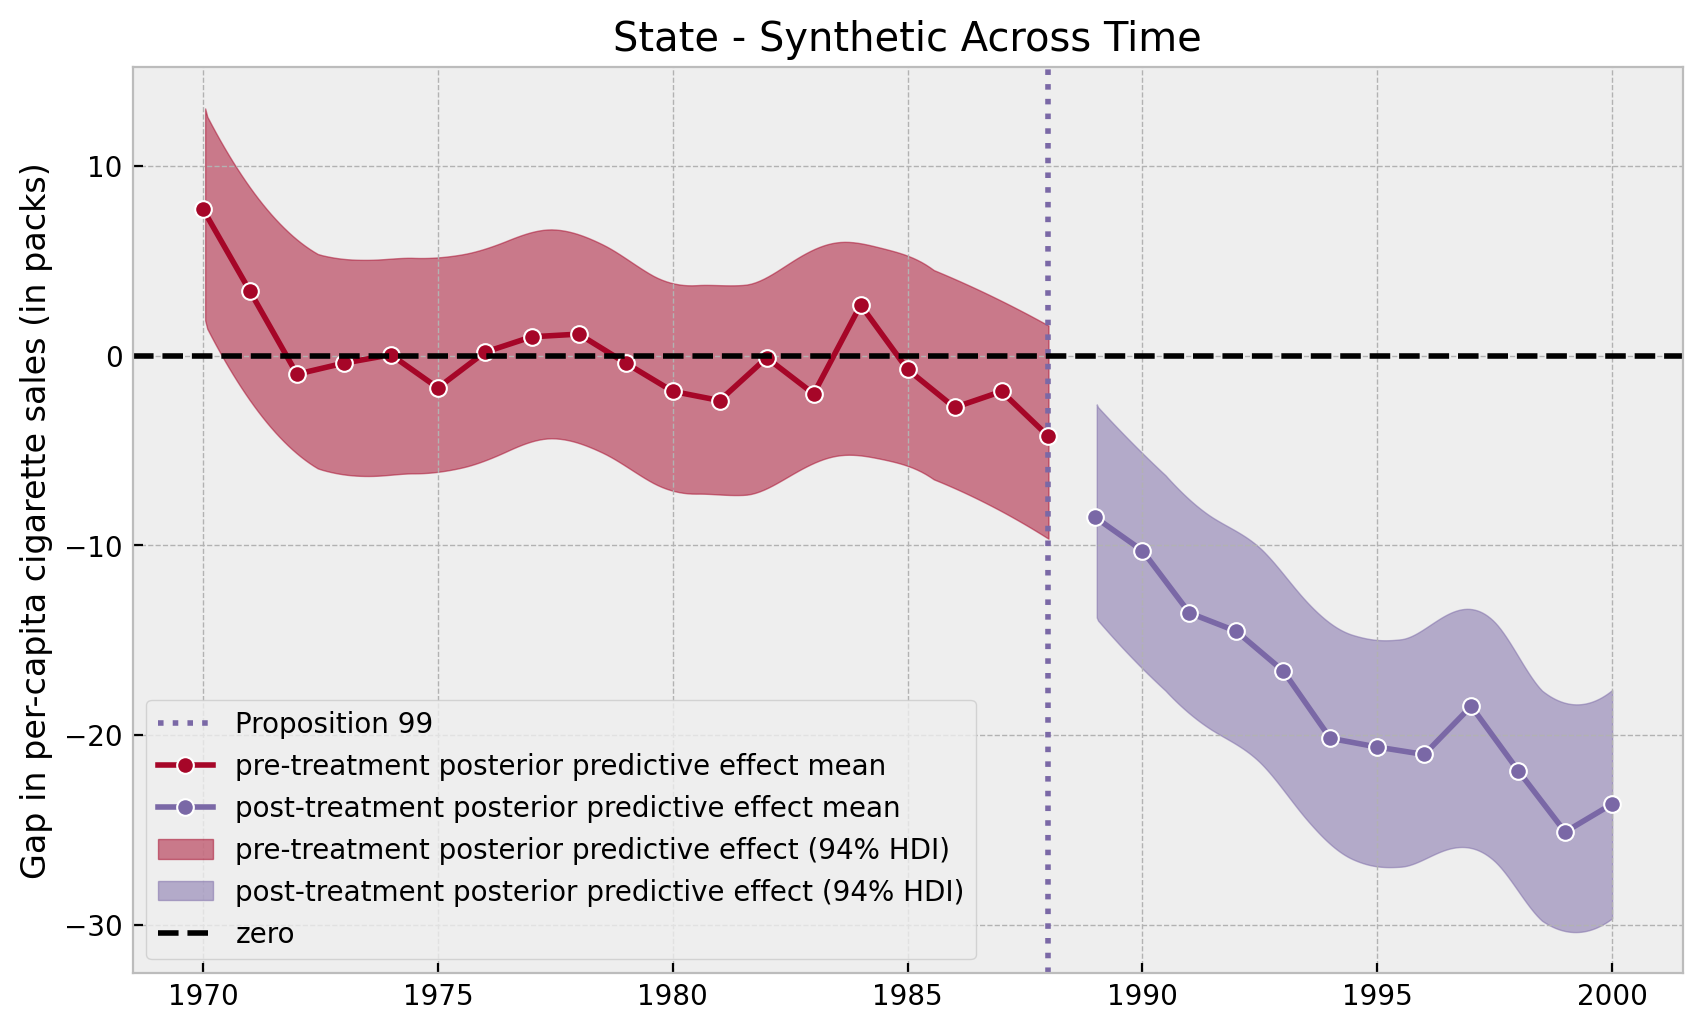

In [140]:
fig, ax = plt.subplots()

ax.axvline(
    x=1988,
    linestyle=":",
    lw=2,
    color="C2",
    label="Proposition 99",
)
sns.lineplot(
    x=pre_years,
    y=y_pre[:n_pre] - pre_posterior_mean,
    color="C1",
    marker="o",
    label="pre-treatment posterior predictive effect mean",
    ax=ax
)
sns.lineplot(
    x=post_years,
    y=y_post[:n_post] - post_posterior_mean,
    color="C2",
    marker="o",
    label="post-treatment posterior predictive effect mean",
    ax=ax
)
az.plot_hdi(
    x=pre_years,
    y=y_pre[:n_pre] - posterior_predictive_pre.posterior_predictive["likelihood"][:, :, : n_pre],
    smooth=True,
    color="C1",
    fill_kwargs={"label": "pre-treatment posterior predictive effect (94% HDI)"},
    ax=ax
)
az.plot_hdi(
    x=post_years,
    y=y_post[:n_post] - posterior_predictive_post.posterior_predictive["likelihood"][:, :, : n_post],
    smooth=True,
    color="C2",
    fill_kwargs={"label": "post-treatment posterior predictive effect (94% HDI)"},
    ax=ax
)
ax.axhline(y=0.0, color="black", linestyle="--", label="zero")
ax.legend(loc="lower left")
ax.set(
    title="State - Synthetic Across Time",
    ylabel="Gap in per-capita cigarette sales (in packs)"
);

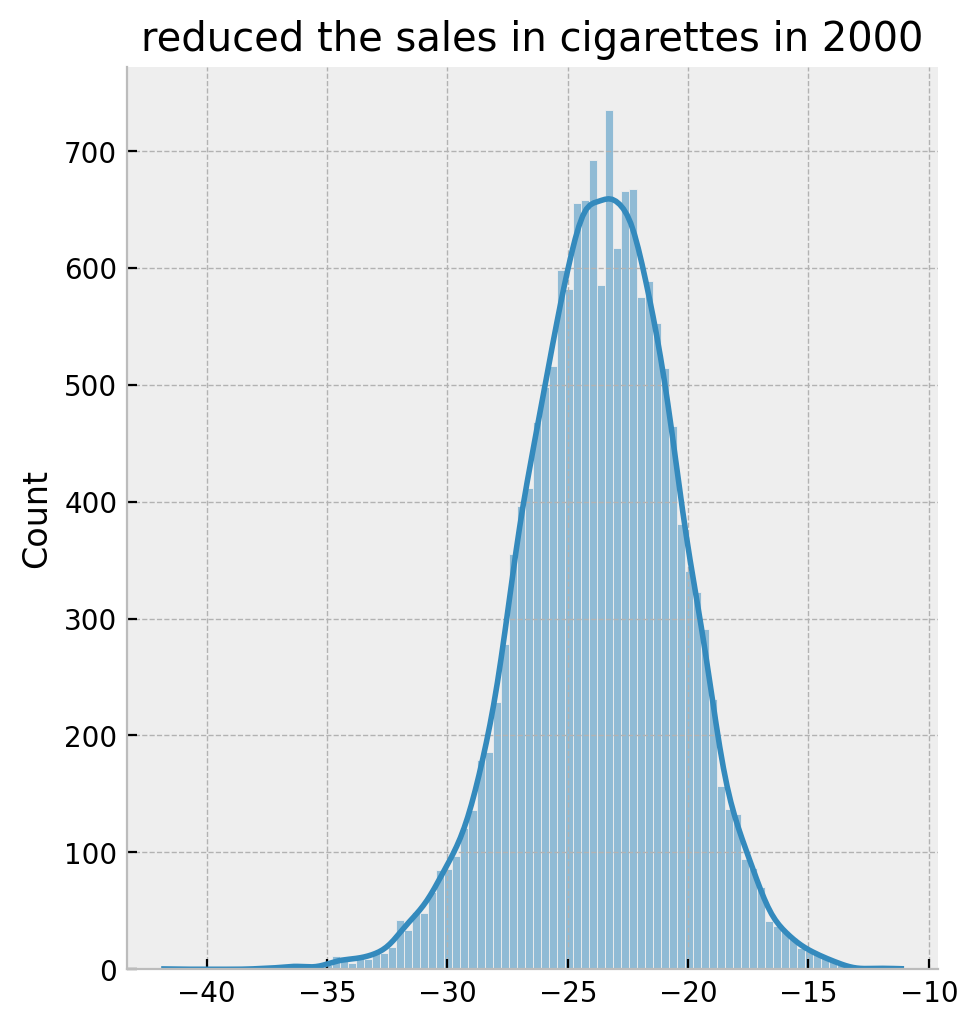

In [141]:
g = (
    (
        y_post[:n_post] - posterior_predictive_post.posterior_predictive["likelihood"][:, :, : n_post]
    )
    [:, :, -1]
    .stack(samples=("chain", "draw"))
    .pipe((sns.displot, "data"), kde=True)
)
g.set(title="reduced the sales in cigarettes in 2000");

---

In [16]:
def run_synthetic_control(pre_df: pd.DataFrame, post_df: pd.DataFrame, idx: int) -> tuple:

    y_pre = pre_df[idx].to_numpy()
    x_pre = pre_df.drop(columns=idx).to_numpy()
    pre_years = pre_df.reset_index(inplace=False).year.unique()
    n_pre = pre_years.size

    y_post = post_df[idx].to_numpy()
    x_post = post_df.drop(columns=idx).to_numpy()
    post_years = post_df.reset_index(inplace=False).year.unique()
    n_post = post_years.size

    k = pre_df.shape[0]

    with pm.Model() as model:
        x = pm.MutableData(name="x", value=x_pre)
        y = pm.MutableData(name="y", value=y_pre)

        beta = pm.Dirichlet(name="beta", a=(1 / k) * np.ones(k))
        sigma = pm.HalfNormal(name="sigma", sigma=5)
        mu = pm.Deterministic(name="mu", var=pm.math.dot(x, beta))
        likelihood = pm.Normal(name="likelihood", mu=mu, sigma=sigma, observed=y)

        idata = pm.sampling_jax.sample_numpyro_nuts(draws=4000, chains=4)
        posterior_predictive_pre = pm.sample_posterior_predictive(trace=idata)

        pm.set_data(new_data={"x": x_post, "y": y_post})
        posterior_predictive_post = pm.sample_posterior_predictive(
            trace=idata, var_names=["likelihood"]
        )

        error_pre = (
            y_pre[:n_pre] - posterior_predictive_pre.posterior_predictive["likelihood"][:, :, : n_pre]
        )
        error_post = (
            y_post[:n_post] - posterior_predictive_post.posterior_predictive["likelihood"][:, :, : n_post]
        )

    return error_pre, error_post

In [ ]:
from tqdm.notebook import tqdm

results = {
    idx: run_synthetic_control(pre_df=pre_df, post_df=post_df, idx=idx)
    for idx in tqdm(df["state"].unique())
}


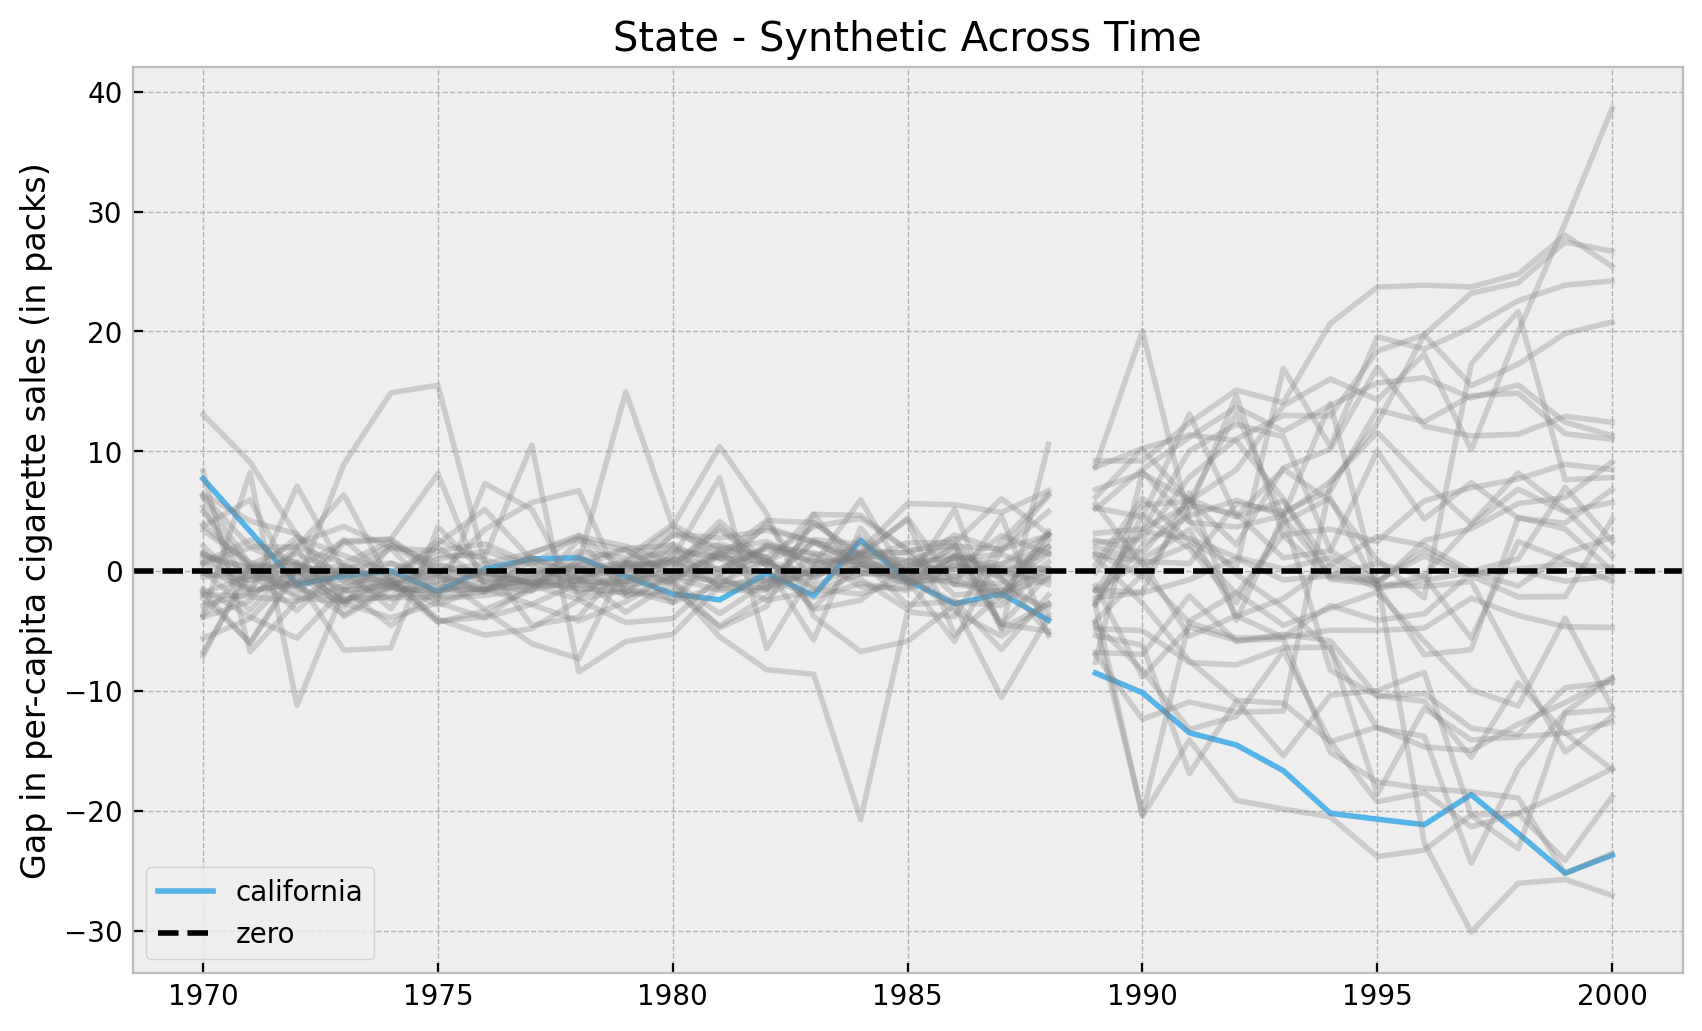

In [121]:
fig, ax = plt.subplots()

for idx in df["state"].unique():
    error_pre, error_post = results[idx]
    sigma_pre = error_pre.stack(samples=("chain", "draw")).std(axis=1).min().item()
    if sigma_pre < 10:
        color = "C6" if idx == 3 else "gray"
        alpha = 1 if idx == 3 else 0.3
        label = "california" if idx == 3 else None
        sns.lineplot(
            x=pre_years,
            y=error_pre.stack(samples=("chain", "draw")).mean(axis=1),
            color=color,
            alpha=alpha,
            ax=ax
        )
        sns.lineplot(
            x=post_years,
            y=error_post.stack(samples=("chain", "draw")).mean(axis=1),
            color=color,
            alpha=alpha,
            label=label,
            ax=ax
        )
ax.axhline(y=0.0, color="black", linestyle="--", label="zero")
ax.legend(loc="lower left")
ax.set(
    title="State - Synthetic Across Time",
    ylabel="Gap in per-capita cigarette sales (in packs)"
);

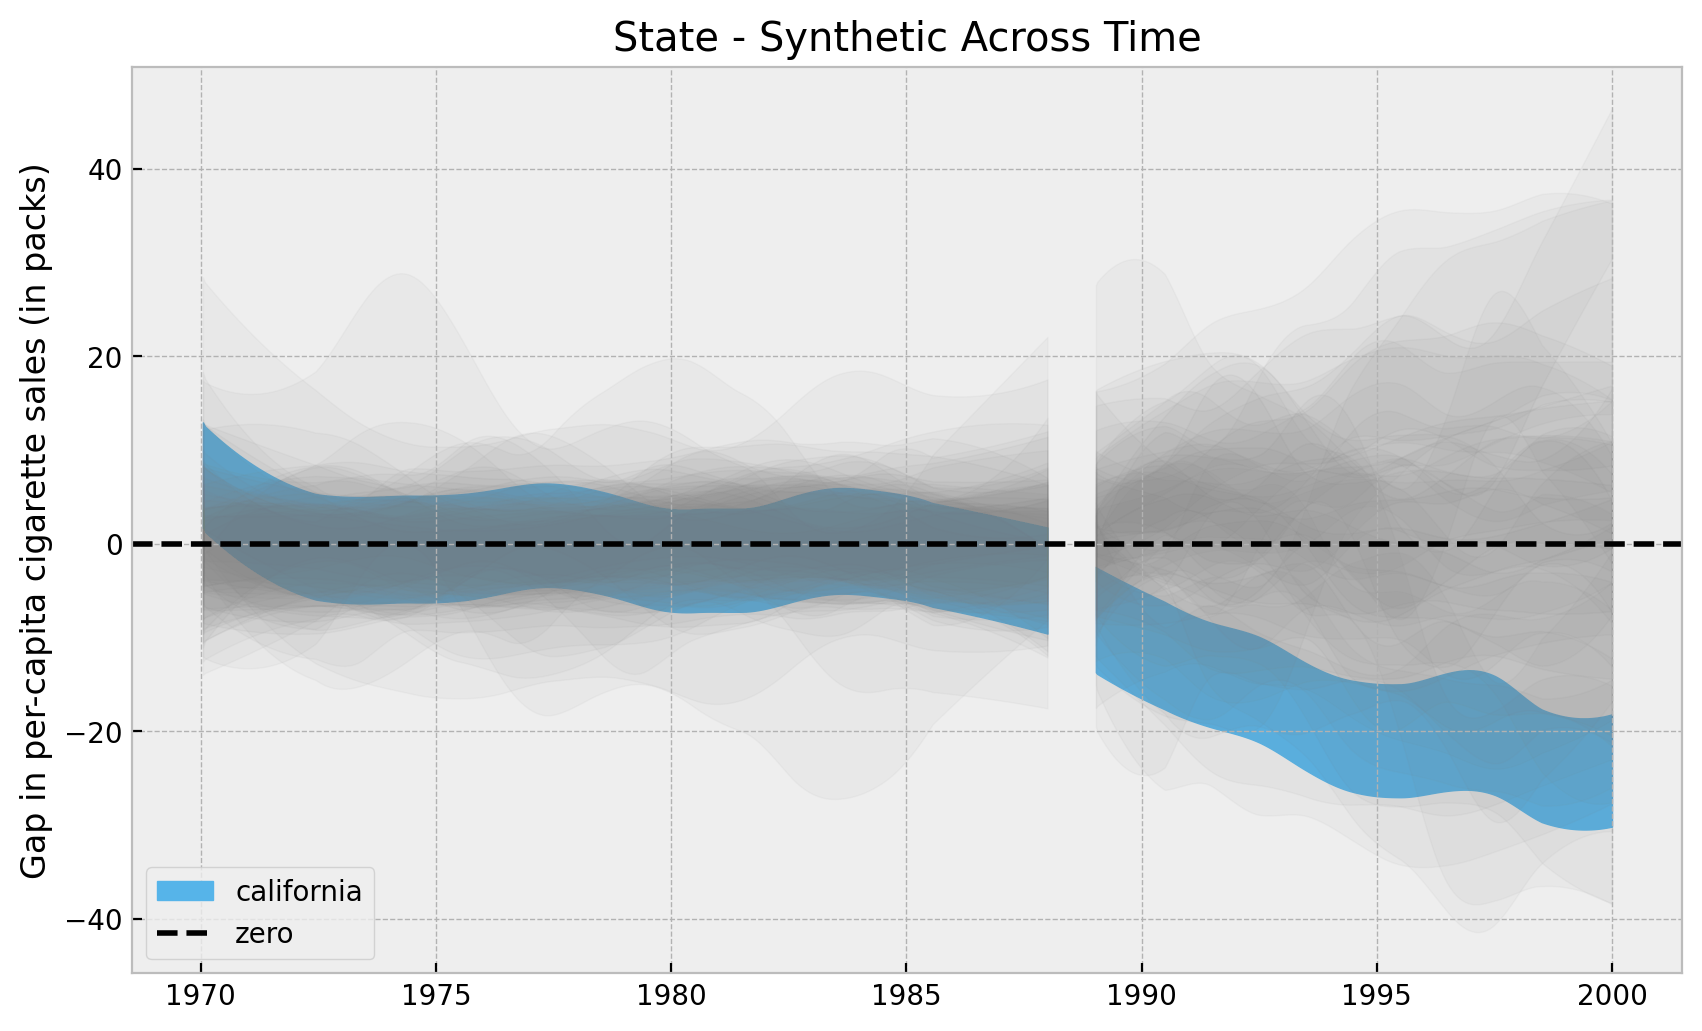

In [60]:
fig, ax = plt.subplots()

for idx in df["state"].unique():
    error_pre, error_post = results[idx]
    sigma_pre = error_pre.stack(samples=("chain", "draw")).std(axis=1).min().item()
    if sigma_pre < 10:
        color = "C6" if idx == 3 else "gray"
        alpha = 1 if idx == 3 else 0.05
        label = "california" if idx == 3 else None
        az.plot_hdi(
            x=pre_years,
            y=error_pre,
            smooth=True,
            color=color,
            fill_kwargs={"alpha": alpha},
            ax=ax
        )
        az.plot_hdi(
            x=post_years,
            y=error_post,
            smooth=True,
            color=color,
            fill_kwargs={"alpha": alpha, "label": label},
            ax=ax
        )
ax.axhline(y=0.0, color="black", linestyle="--", label="zero")
ax.legend(loc="lower left")
ax.set(
    title="State - Synthetic Across Time",
    ylabel="Gap in per-capita cigarette sales (in packs)"
);

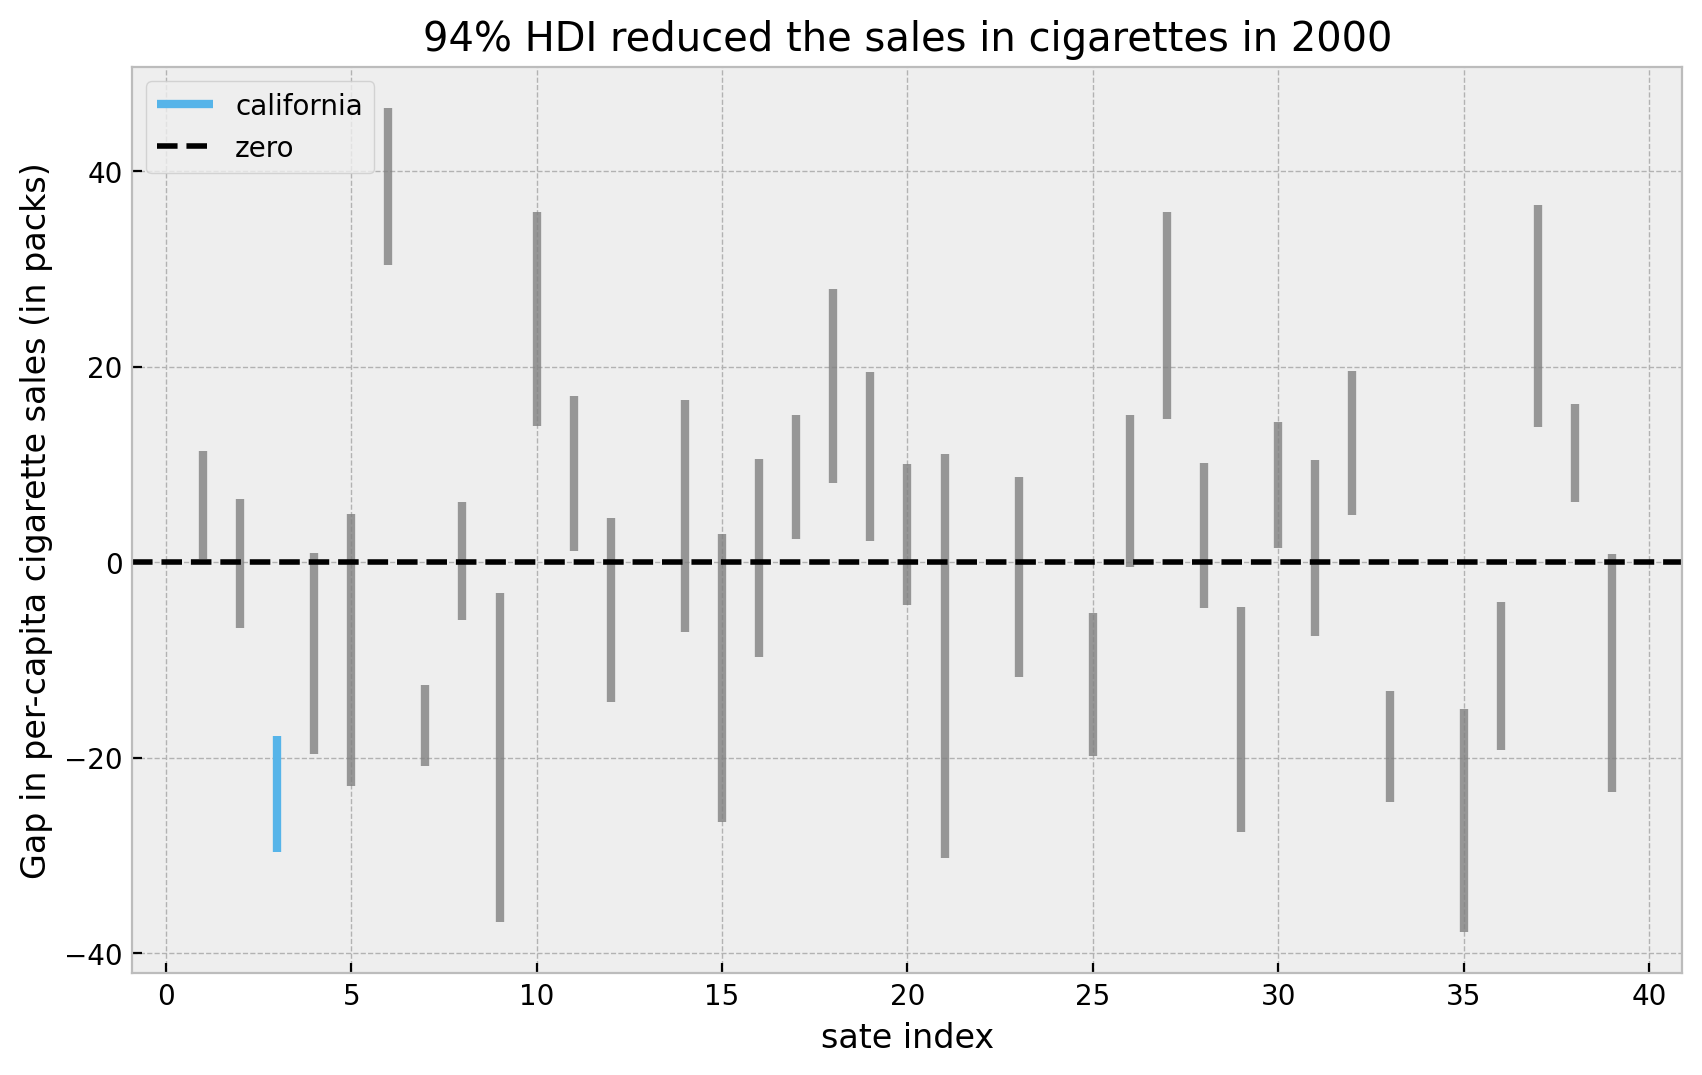

In [90]:
fig, ax = plt.subplots()

for idx in df["state"].unique():
    error_pre, error_post = results[idx]
    sigma_pre = error_pre.stack(samples=("chain", "draw")).std(axis=1).min().item()
    if sigma_pre < 10:
        color = "C6" if idx == 3 else "gray"
        alpha = 1 if idx == 3 else 0.8
        label = "california" if idx == 3 else None
        hdi = az.hdi(error_post[:, :, -1])["likelihood"].to_numpy()
        ax.vlines(
            x=idx,
            ymin=hdi[0],
            ymax=hdi[1],
            linestyle="solid",
            linewidth=3,
            color=color,
            alpha=alpha,
            label=label
        )

ax.axhline(y=0.0, color="black", linestyle="--", label="zero")
ax.legend(loc="upper left")
ax.set(
    title="94% HDI reduced the sales in cigarettes in 2000",
    xlabel="sate index",
    ylabel="Gap in per-capita cigarette sales (in packs)"
);

In [192]:
for idx in df["state"].unique():
    error_pre, error_post = results[idx]
    sigma_pre = error_pre.stack(samples=("chain", "draw")).std(axis=1).min().item()
    if sigma_pre >= 10:
        print(idx)

13
22
24
34


In [193]:
cal_samples = np.vstack([v[1].stack(samples=("chain", "draw")).T.to_numpy() for k, v in results.items() if k == 3])

non_cal_samples = np.vstack(
    [ v[1].stack(samples=("chain", "draw")).T.to_numpy() for k, v in results.items() if k not in [3, 13, 22, 24, 34]]
)


s = cal_samples[:, -1].size

(cal_samples[:, -1] < np.random.choice(a=non_cal_samples[:, -1], size=s)).sum() / s

0.941875

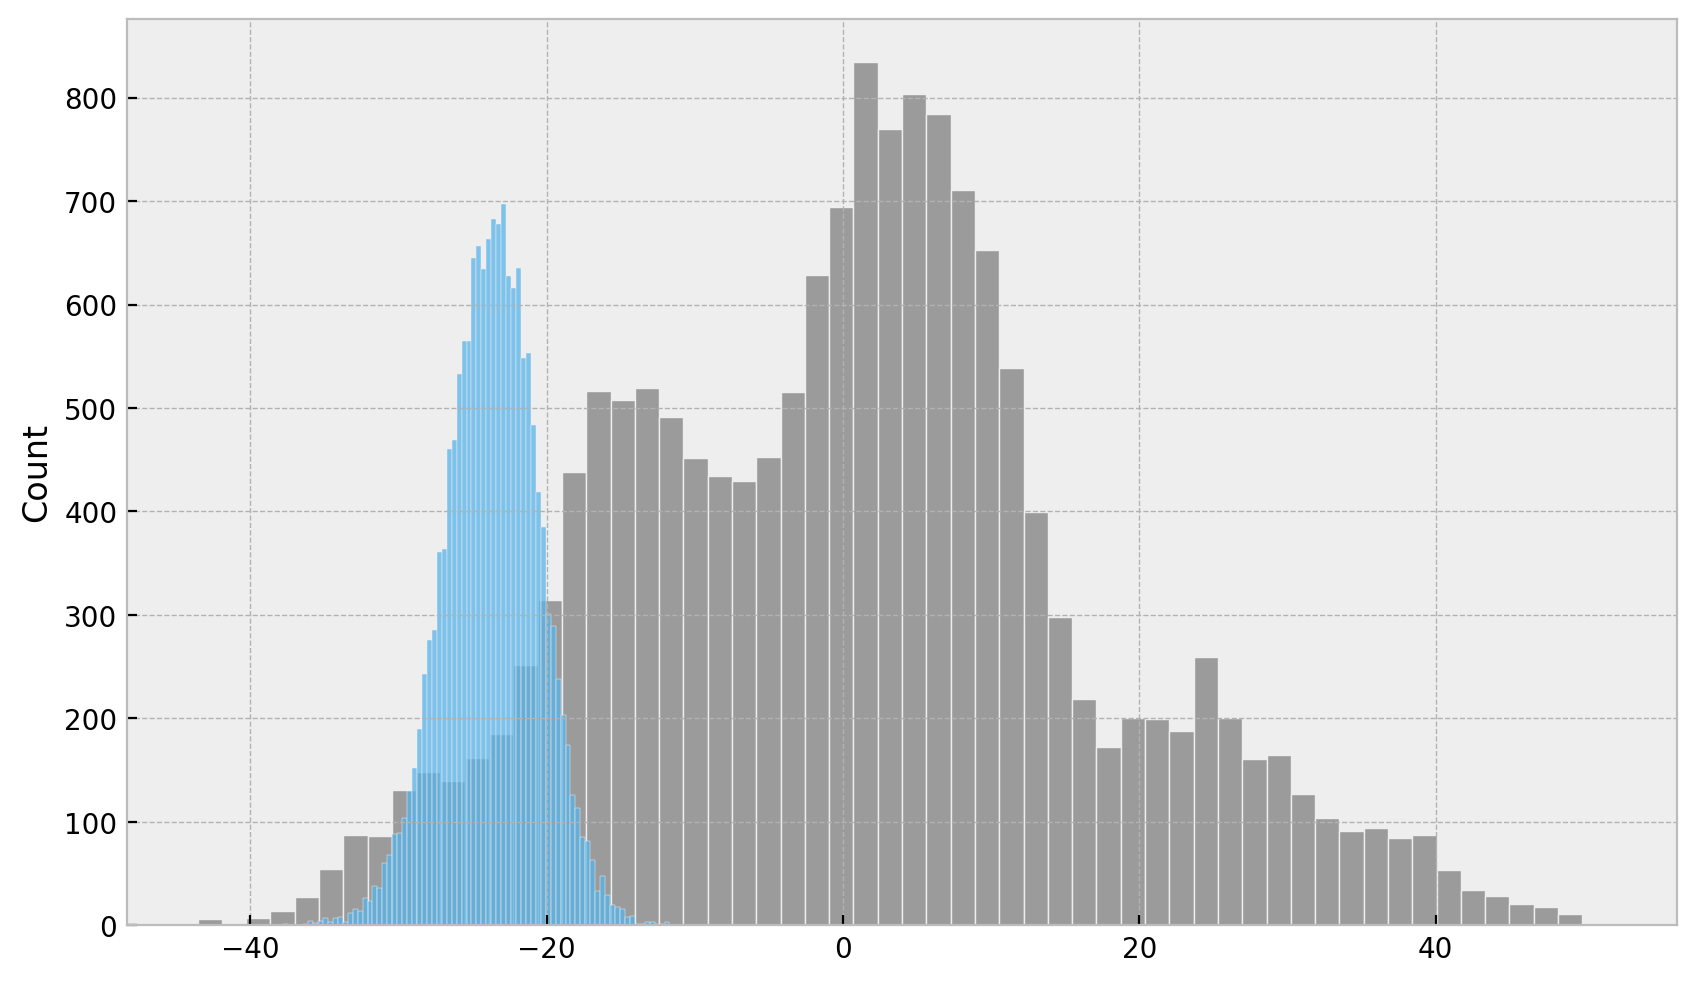

In [194]:
sns.histplot(np.random.choice(a=non_cal_samples[:, -1], size=s), color="gray")
sns.histplot(cal_samples[:, -1], color="C6")

In [29]:
# import pickle

# filehandler = open("results.pkl", 'wb') 
# pickle.dump(results, filehandler)

# filehandler = open("results.pkl", 'rb') 
# r = pickle.load(filehandler)